<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

# Загрузка данных

In [ ]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=2943f666-49cf-4adc-91c8-1f4b4c754389
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 81.0MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
lesions[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

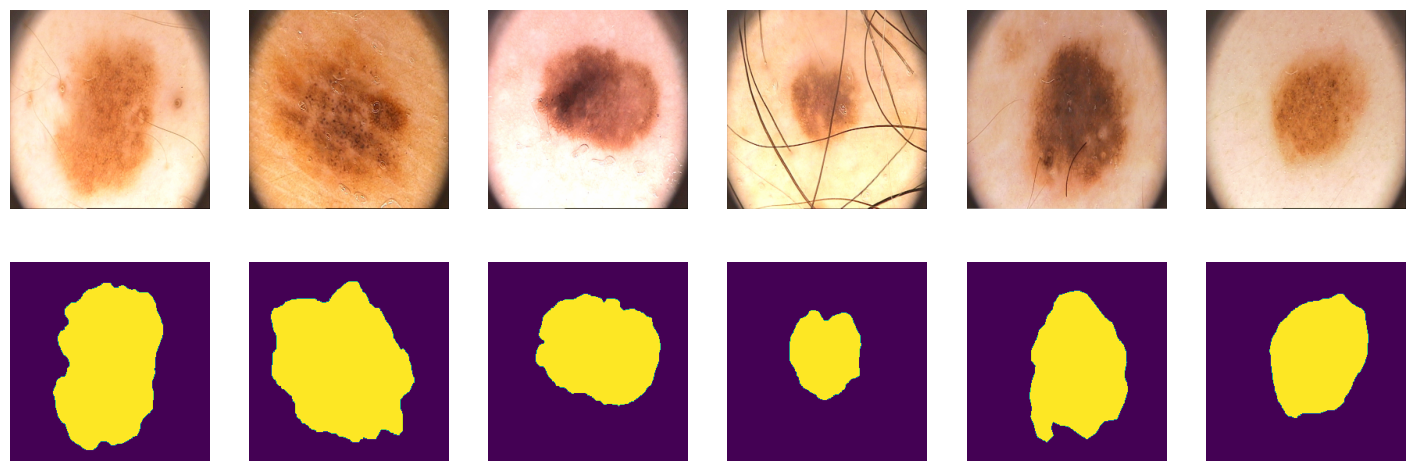

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 24.1 MB/s eta 0:00:00


In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Обучение SegNet

## BCE Loss 

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real):
  loss = y_pred-y_pred*y_real+torch.log(1+torch.exp(-y_pred))
  return torch.sum(loss)

def bce_true(y_pred, y_real):
  Y_pred = 1/(1+torch.exp(-y_pred))
  loss = - torch.sum(y_real * torch.log(Y_pred)+(1-y_real) * torch.log(1-Y_pred))
  return loss

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.303506851196289
BCE loss честно посчитанный = 4.303506851196289
BCE loss from torch bce_torch = 4.303506851196289
BCE loss from torch with logits bce_torch = 4.303506851196289


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 17.071866989135742
BCE loss честно посчитанный = 17.071868896484375
BCE loss from torch bce_torch = 17.071868896484375
BCE loss from torch with logits bce_torch = 17.071866989135742


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 5.77MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 7.12MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

<ipython-input-22-cd9dbfff2c1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
<ipython-input-

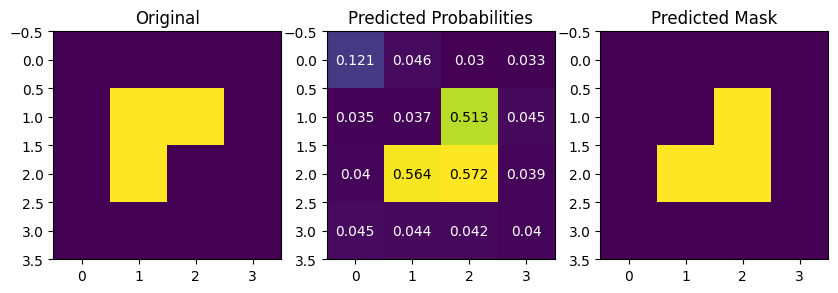

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet


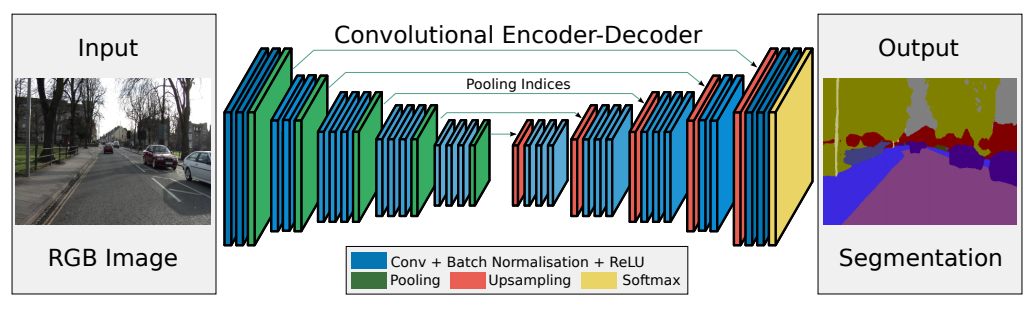

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1) -> None:
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_c, in_c, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=64):
        super().__init__()

        # VGG-16 architecture
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlock(features * 4, features * 8, depth=3)

        # bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3)
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3)

        # decoder (upsampling)
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(features, out_channels, classification=True)

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)
        output = self.dec3(d2, ind0)

        return output # no activation

In [ ]:
segnet_model = SegNet().to(device)

## Тренировка

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train_one_epoch(model,device,optimizer,criterion,dataloader):

    epoch_loss = 0
    epoch_iou = 0
    model.train()
    for X_batch, Y_batch in dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch) # forward-pass

        loss.backward()  # backward-pass
        optimizer.step()  # update weights
        optimizer.zero_grad() # set parameter gradients to zero

        epoch_loss += loss
        epoch_iou += iou_score(Y_pred, Y_batch)

    epoch_loss = epoch_loss/len(dataloader)
    epoch_iou = epoch_iou/len(dataloader)

    return model, epoch_loss, epoch_iou

def eval_one_epoch(model,device,criterion,dataloader):

    epoch_loss = 0
    epoch_iou = 0
    model.eval()
    with torch.no_grad():
        for X_batch, Y_batch in dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)

            epoch_loss += loss
            epoch_iou += iou_score(Y_pred, Y_batch)

    epoch_loss = epoch_loss/len(dataloader)
    epoch_iou = epoch_iou/len(dataloader)

    return model, epoch_loss, epoch_iou


def train(model, device, epochs, optimizer, criterion, train_dataloader, val_dataloader, dir):


    history = {'train': {'loss': [], 'iou': []},
               'val': {'loss': [], 'iou': []}}

    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss, train_iou = train_one_epoch(model, device, optimizer, criterion, train_dataloader)
        model, val_loss, val_iou = eval_one_epoch(model, device, criterion, val_dataloader)
        print('\n', f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')

        history['train']['loss'].append(train_loss.cpu().detach().numpy())
        history['train']['iou'].append(train_iou.cpu().detach().numpy())

        history['val']['loss'].append(val_loss.cpu().detach().numpy())
        history['val']['iou'].append(val_iou.cpu().detach().numpy())

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_epoch = epoch
          torch.save(model.state_dict(), f'{dir}/{epoch}.pth')

    return model, history, best_epoch

In [ ]:
epochs = 100
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
criterion = nn.BCELoss() # (sigmoid(y_pred), y_real)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
segnet_model, history, best_epoch = train(segnet_model, device,epochs, optimizer, criterion, train_dataloader, valid_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch 0: train loss = 0.6657414436340332
Epoch 0: val loss = 0.6881178021430969

 Epoch 1: train loss = 0.6560255289077759
Epoch 1: val loss = 0.6611330509185791

 Epoch 2: train loss = 0.4998486042022705
Epoch 2: val loss = 0.6190674304962158

 Epoch 3: train loss = 0.44252318143844604
Epoch 3: val loss = 0.631524384021759

 Epoch 4: train loss = 0.3459063470363617
Epoch 4: val loss = 0.6719099283218384

 Epoch 5: train loss = 0.2916884124279022
Epoch 5: val loss = 0.5805577039718628

 Epoch 6: train loss = 0.25802093744277954
Epoch 6: val loss = 0.666883111000061

 Epoch 7: train loss = 0.2622697651386261
Epoch 7: val loss = 0.5306389331817627

 Epoch 8: train loss = 0.23083609342575073
Epoch 8: val loss = 0.5087636709213257

 Epoch 9: train loss = 0.22321724891662598
Epoch 9: val loss = 0.39050620794296265

 Epoch 10: train loss = 0.21058307588100433
Epoch 10: val loss = 0.2884448766708374

 Epoch 11: train loss = 0.20511937141418457
Epoch 11: val loss = 0.24401506781578064

 Epoc

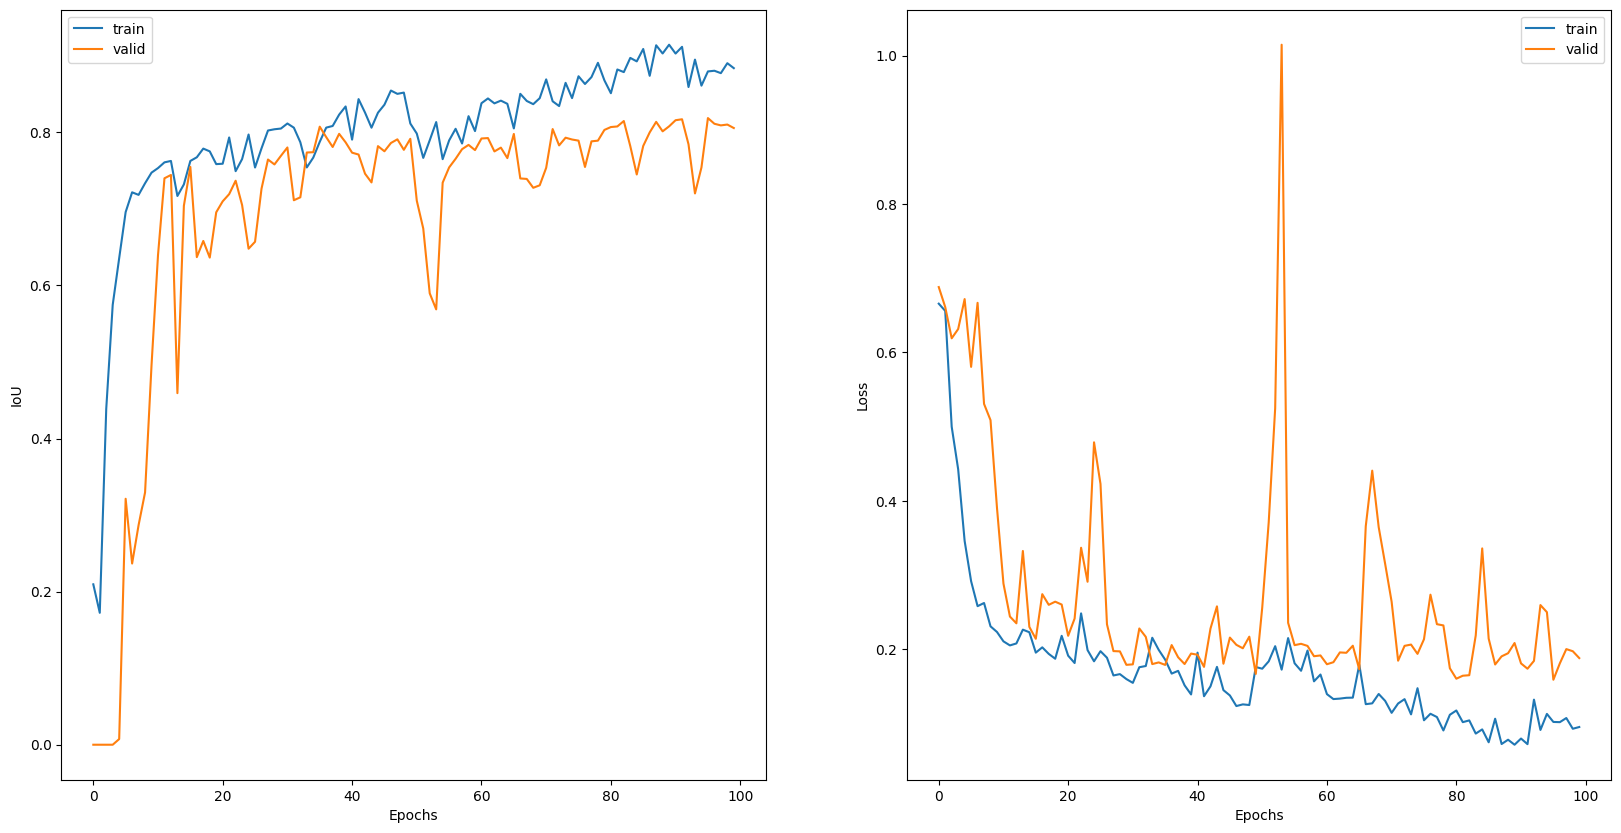

In [ ]:
fig, axs = plt.subplots(1,2, figsize=[20,10])
axs[0].plot(history['train']['iou'], label="train")
axs[0].plot(history['val']['iou'], label="valid")
axs[0].legend(loc='best')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("IoU")

axs[1].plot(history['train']['loss'], label="train")
axs[1].plot(history['val']['loss'], label="valid")
axs[1].legend(loc='best')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")

plt.show()

In [ ]:
best_epoch

95

## Инференс 

In [ ]:
def test(model, dataloader, device, best_epoch, dir):

    model.load_state_dict(torch.load(f'{dir}/{best_epoch}.pth', weights_only=False))
    model.eval()
    model.to(device)
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          avg_iou += iou_score(Y_pred, Y_batch) # , threshold = 0.5)
      avg_iou = avg_iou / len(dataloader)

    return avg_iou

In [ ]:
iou_test = test(segnet_model, test_dataloader, device, best_epoch)
print(iou_test.item())

0.8270301818847656


# Мир других лоссов!

## Дополнительные функции потерь

### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5, epsilon: float = 1e-8):
    '''
    Это именно метрика, не лосс.
    '''
    probs = torch.sigmoid(logits)
    preds = torch.where(probs > threshold, 1, 0)

    tp = torch.sum(preds*labels)
    fp = torch.sum(preds) - tp
    fn = torch.sum(labels) - tp

    score = (2*tp + epsilon) / (2*tp + fp + fn + epsilon)
    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor, epsilon: float = 1e-8):

    '''
    Это лосс.
    '''
    probs = torch.sigmoid(logits)

    tp = torch.sum(probs*labels)
    fp = torch.sum(probs) - tp
    fn = torch.sum(labels) - tp

    dice = (2*tp + epsilon) / (2*tp + fp + fn + epsilon)
    loss = 1 - dice
    return loss

In [ ]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0de6a0f1b7473991ce2fd6f0c996cf3834a585840704754a3340d892aafae403
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=84514a2bd5793a8e9134cb1efba86dcd46a30df5de7acf382d95e5240213f624
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

Проверка на корректность:

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, gamma = 2, eps=1e-8):
    logpt = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")
    pt = torch.exp(-logpt)
    focal_term = (1.0 - pt).pow(gamma)
    loss = focal_term * logpt
    loss = torch.sum(loss)
    return loss

# Dice Loss

In [ ]:
segnet_dice_loss = SegNet().to(device)

In [ ]:
epochs = 100
optimizer = torch.optim.Adam(segnet_dice_loss.parameters(), lr=1e-3)
criterion = DiceLoss(mode='binary')

In [ ]:
segnet_dice_loss, history, best_epoch = train(segnet_dice_loss, device, epochs, optimizer, criterion, train_dataloader, valid_dataloader, 'dice')

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch 0: train loss = 0.5697948932647705
Epoch 0: val loss = 0.6250137090682983

 Epoch 1: train loss = 0.4572484493255615
Epoch 1: val loss = 0.5373794436454773

 Epoch 2: train loss = 0.3736388087272644
Epoch 2: val loss = 0.5099292993545532

 Epoch 3: train loss = 0.3377550542354584
Epoch 3: val loss = 0.5575189590454102

 Epoch 4: train loss = 0.2802346646785736
Epoch 4: val loss = 0.485346257686615

 Epoch 5: train loss = 0.24621805548667908
Epoch 5: val loss = 0.31580471992492676

 Epoch 6: train loss = 0.21679653227329254
Epoch 6: val loss = 0.3279639482498169

 Epoch 7: train loss = 0.19530987739562988
Epoch 7: val loss = 0.25759631395339966

 Epoch 8: train loss = 0.1767980456352234
Epoch 8: val loss = 0.26264044642448425

 Epoch 9: train loss = 0.20197933912277222
Epoch 9: val loss = 0.270552396774292

 Epoch 10: train loss = 0.1437201201915741
Epoch 10: val loss = 0.28994953632354736

 Epoch 11: train loss = 0.15327368676662445
Epoch 11: val loss = 0.21345359086990356

 Ep

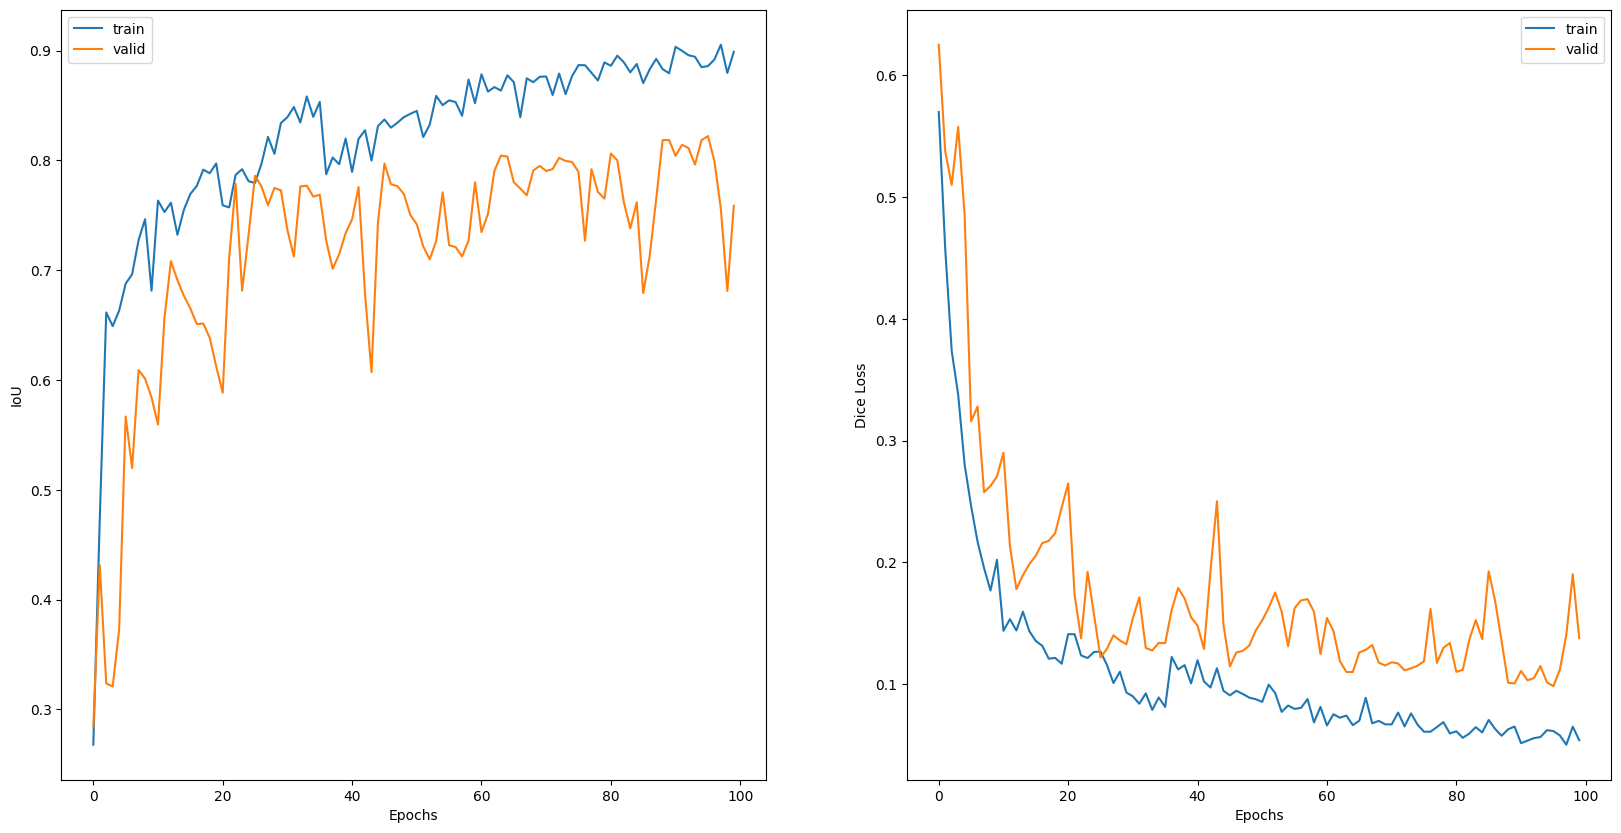

In [ ]:
fig, axs = plt.subplots(1,2, figsize=[20,10])
axs[0].plot(history['train']['iou'], label="train")
axs[0].plot(history['val']['iou'], label="valid")
axs[0].legend(loc='best')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("IoU")

axs[1].plot(history['train']['loss'], label="train")
axs[1].plot(history['val']['loss'], label="valid")
axs[1].legend(loc='best')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Dice Loss")

plt.show()

In [ ]:
iou_test = test(segnet_dice_loss, test_dataloader, device, 95, 'dice')
print(iou_test.item())

0.8280906677246094


In [ ]:
best_epoch

95

# Focal Loss

In [ ]:
segnet_focal_loss = SegNet().to(device)

In [ ]:
optimizer = torch.optim.Adam(segnet_focal_loss.parameters(), lr=1e-3)

from segmentation_models_pytorch.losses import FocalLoss
criterion = FocalLoss(mode='binary')

In [ ]:
segnet_focal_loss, history, best_epoch = train(segnet_focal_loss, device, epochs, optimizer, criterion, train_dataloader, valid_dataloader, 'focal')

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch 0: train loss = 0.19313186407089233
Epoch 0: val loss = 0.1673891842365265

 Epoch 1: train loss = 0.14304877817630768
Epoch 1: val loss = 0.23687781393527985

 Epoch 2: train loss = 0.12176680564880371
Epoch 2: val loss = 0.5196523070335388

 Epoch 3: train loss = 0.08129987120628357
Epoch 3: val loss = 0.19453810155391693

 Epoch 4: train loss = 0.07960623502731323
Epoch 4: val loss = 0.424149751663208

 Epoch 5: train loss = 0.0747910887002945
Epoch 5: val loss = 0.1949111819267273

 Epoch 6: train loss = 0.0651191771030426
Epoch 6: val loss = 0.16122892498970032

 Epoch 7: train loss = 0.06294139474630356
Epoch 7: val loss = 0.1482609212398529

 Epoch 8: train loss = 0.06149164214730263
Epoch 8: val loss = 0.11899343132972717

 Epoch 9: train loss = 0.057692207396030426
Epoch 9: val loss = 0.08027970790863037

 Epoch 10: train loss = 0.05764387547969818
Epoch 10: val loss = 0.06368052214384079

 Epoch 11: train loss = 0.061062850058078766
Epoch 11: val loss = 0.059587623924

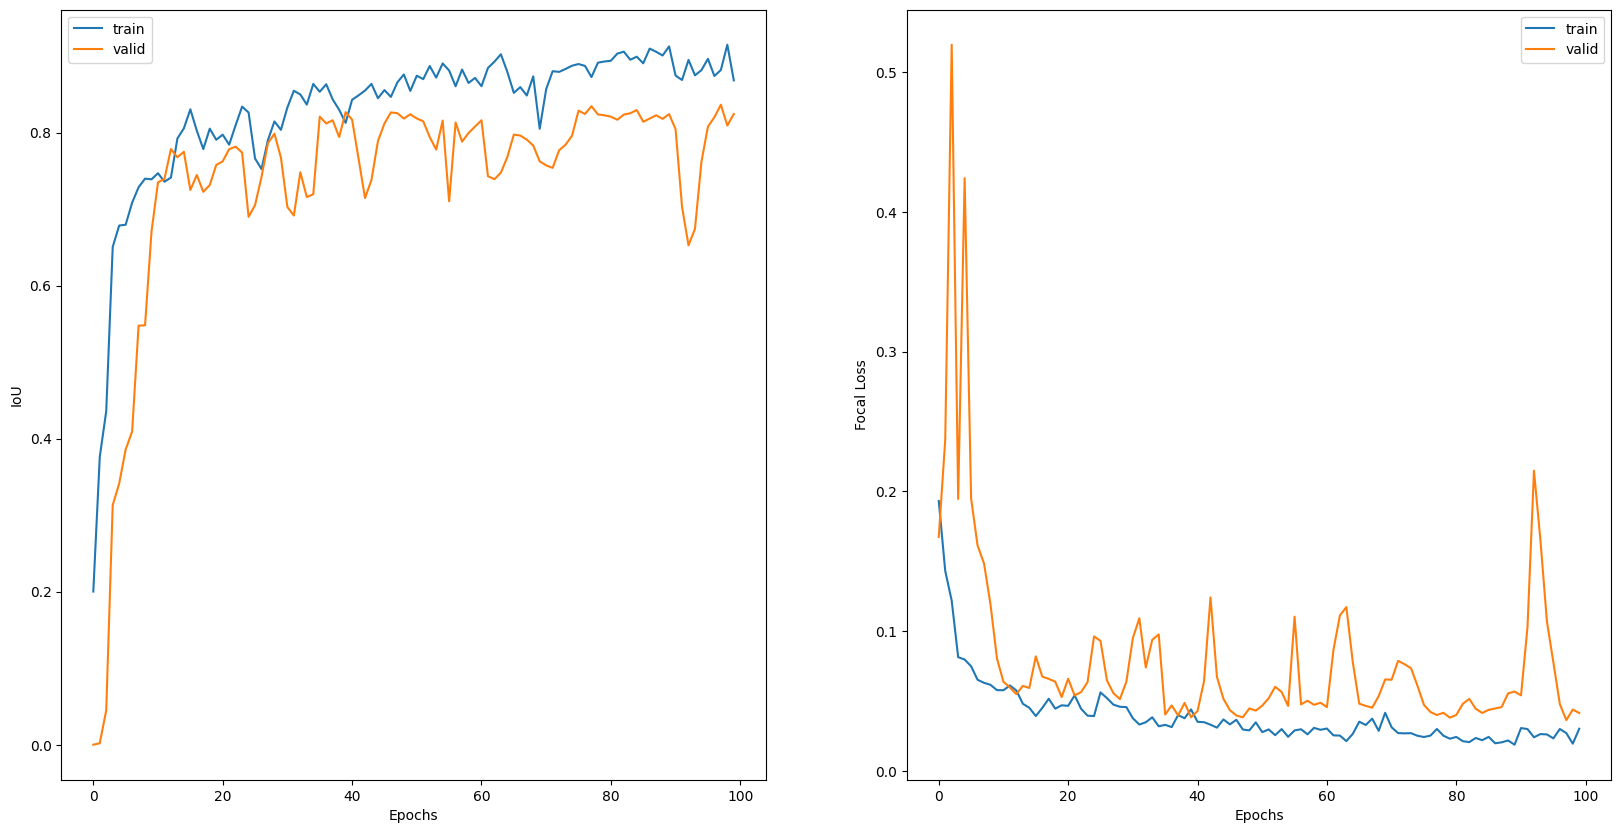

In [ ]:
fig, axs = plt.subplots(1,2, figsize=[20,10])
axs[0].plot(history['train']['iou'], label="train")
axs[0].plot(history['val']['iou'], label="valid")
axs[0].legend(loc='best')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("IoU")

axs[1].plot(history['train']['loss'], label="train")
axs[1].plot(history['val']['loss'], label="valid")
axs[1].legend(loc='best')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Focal Loss")

plt.show()

In [ ]:
iou_test = test(segnet_focal_loss, test_dataloader, device, best_epoch, 'focal')
print(iou_test.item())

0.7969455718994141


In [ ]:
best_epoch

97

Модель сходится быстрее на Focal Loss.
Модель показывает наилучшую IoU метрику на Dice Loss (82,8%).

# Новая модель!

## U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

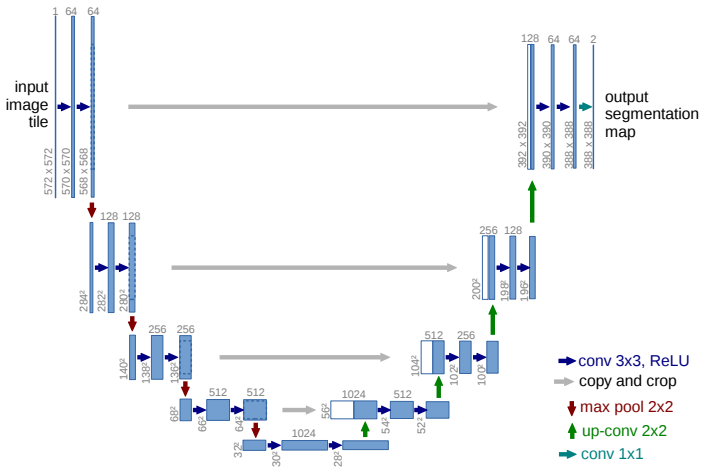

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
unet_model_bce = UNet().to(device)

# BCE Loss

In [ ]:
epochs = 100
optimizer = torch.optim.Adam(unet_model_bce.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
unet_model_bce, history, best_epoch = train(unet_model_bce, device, epochs, optimizer, criterion, train_dataloader, valid_dataloader, 'unet_bce')

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch 0: train loss = 0.5318612456321716
Epoch 0: val loss = 0.6303367614746094

 Epoch 1: train loss = 0.35722437500953674
Epoch 1: val loss = 0.6136059761047363

 Epoch 2: train loss = 0.31802186369895935
Epoch 2: val loss = 0.5885504484176636

 Epoch 3: train loss = 0.2891915440559387
Epoch 3: val loss = 0.5330759286880493

 Epoch 4: train loss = 0.2645573616027832
Epoch 4: val loss = 0.46610027551651

 Epoch 5: train loss = 0.2673192322254181
Epoch 5: val loss = 0.4470858573913574

 Epoch 6: train loss = 0.24980556964874268
Epoch 6: val loss = 1.050427794456482

 Epoch 7: train loss = 0.2257774919271469
Epoch 7: val loss = 0.7021443843841553

 Epoch 8: train loss = 0.19865964353084564
Epoch 8: val loss = 0.3047581613063812

 Epoch 9: train loss = 0.20092228055000305
Epoch 9: val loss = 0.27313223481178284

 Epoch 10: train loss = 0.189097598195076
Epoch 10: val loss = 0.5396419763565063

 Epoch 11: train loss = 0.2149403989315033
Epoch 11: val loss = 0.3018968105316162

 Epoch 12

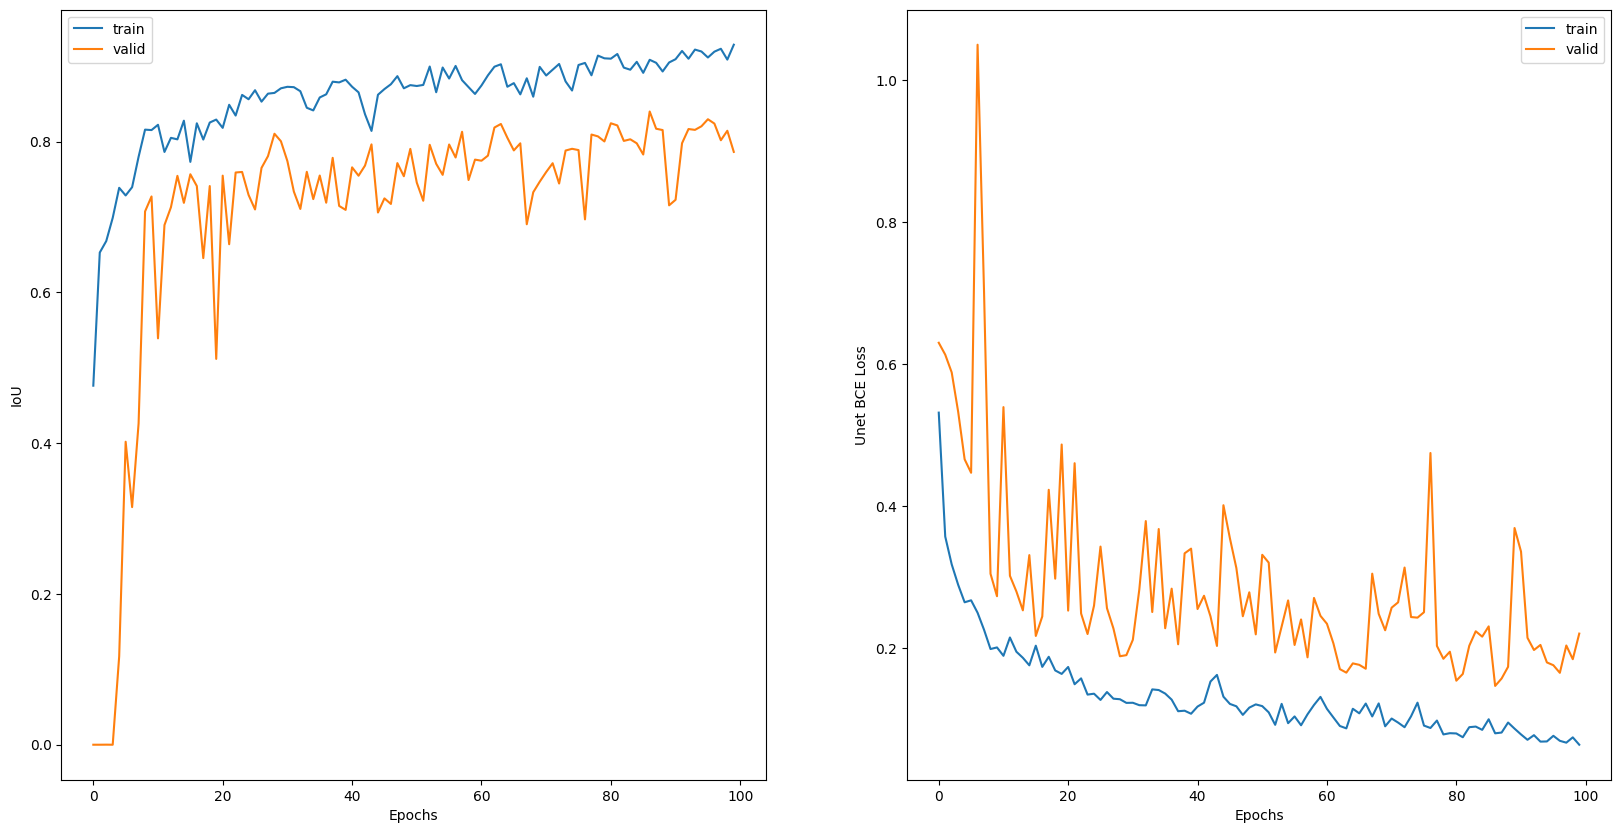

In [ ]:
fig, axs = plt.subplots(1,2, figsize=[20,10])
axs[0].plot(history['train']['iou'], label="train")
axs[0].plot(history['val']['iou'], label="valid")
axs[0].legend(loc='best')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("IoU")

axs[1].plot(history['train']['loss'], label="train")
axs[1].plot(history['val']['loss'], label="valid")
axs[1].legend(loc='best')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Unet BCE Loss")

plt.show()

In [ ]:
best_epoch

86

In [ ]:
iou_test = test(unet_model_bce, test_dataloader, device, best_epoch, 'unet_bce')
print(iou_test.item())

0.8101986050605774


# Dice Loss

In [ ]:
unet_model_dice = UNet().to(device)

In [ ]:
optimizer = torch.optim.Adam(unet_model_dice.parameters(), lr=1e-3)
criterion = DiceLoss(mode='binary')

In [ ]:
unet_model_dice, history, best_epoch = train(unet_model_dice, device, epochs, optimizer, criterion, train_dataloader, valid_dataloader, 'unet_dice')

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch 0: train loss = 0.47071701288223267
Epoch 0: val loss = 0.6234467029571533

 Epoch 1: train loss = 0.3426668643951416
Epoch 1: val loss = 0.5009650588035583

 Epoch 2: train loss = 0.30118662118911743
Epoch 2: val loss = 0.8169039487838745

 Epoch 3: train loss = 0.27729058265686035
Epoch 3: val loss = 0.7755837440490723

 Epoch 4: train loss = 0.2563178837299347
Epoch 4: val loss = 0.6649385690689087

 Epoch 5: train loss = 0.242632657289505
Epoch 5: val loss = 0.6104025840759277

 Epoch 6: train loss = 0.22580215334892273
Epoch 6: val loss = 0.49170175194740295

 Epoch 7: train loss = 0.22207072377204895
Epoch 7: val loss = 0.3152256906032562

 Epoch 8: train loss = 0.21040941774845123
Epoch 8: val loss = 0.3502539098262787

 Epoch 9: train loss = 0.1926097422838211
Epoch 9: val loss = 0.44731050729751587

 Epoch 10: train loss = 0.20309364795684814
Epoch 10: val loss = 0.28913629055023193

 Epoch 11: train loss = 0.18606886267662048
Epoch 11: val loss = 0.21924704313278198



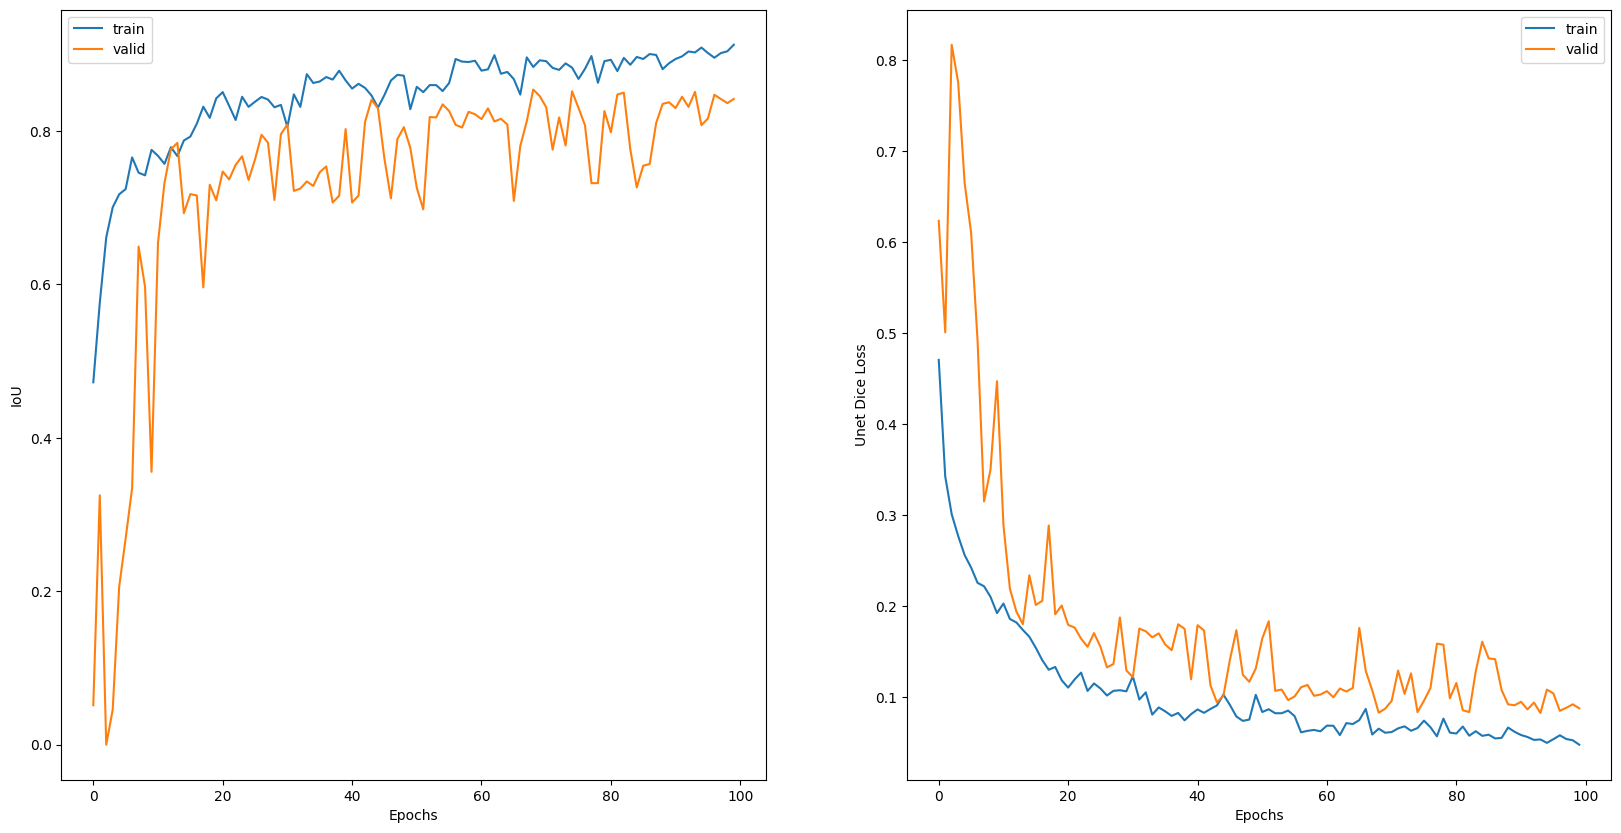

In [ ]:
fig, axs = plt.subplots(1,2, figsize=[20,10])
axs[0].plot(history['train']['iou'], label="train")
axs[0].plot(history['val']['iou'], label="valid")
axs[0].legend(loc='best')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("IoU")

axs[1].plot(history['train']['loss'], label="train")
axs[1].plot(history['val']['loss'], label="valid")
axs[1].legend(loc='best')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Unet Dice Loss")

plt.show()

In [ ]:
best_epoch

93

In [ ]:
iou_test = test(unet_model_dice, test_dataloader, device, best_epoch, 'unet_dice')
print(iou_test.item())

0.8497887849807739


# Focal Loss

In [ ]:
unet_model_focal = UNet().to(device)

In [ ]:
optimizer = torch.optim.Adam(unet_model_focal.parameters(), lr=1e-3)
criterion = FocalLoss(mode='binary')

In [ ]:
unet_model_focal, history, best_epoch = train(unet_model_focal, device, epochs, optimizer, criterion, train_dataloader, valid_dataloader, 'unet_focal')

  0%|          | 0/100 [00:00<?, ?it/s]


 Epoch 0: train loss = 0.12845176458358765
Epoch 0: val loss = 0.1596144586801529

 Epoch 1: train loss = 0.0804329365491867
Epoch 1: val loss = 0.3069223463535309

 Epoch 2: train loss = 0.06949205696582794
Epoch 2: val loss = 0.13779950141906738

 Epoch 3: train loss = 0.06324046105146408
Epoch 3: val loss = 0.13170385360717773

 Epoch 4: train loss = 0.05985211953520775
Epoch 4: val loss = 0.1268782764673233

 Epoch 5: train loss = 0.06091153621673584
Epoch 5: val loss = 0.11454547196626663

 Epoch 6: train loss = 0.0555104985833168
Epoch 6: val loss = 0.15052887797355652

 Epoch 7: train loss = 0.059046801179647446
Epoch 7: val loss = 0.09475964307785034

 Epoch 8: train loss = 0.05643182992935181
Epoch 8: val loss = 0.3216799795627594

 Epoch 9: train loss = 0.05404439568519592
Epoch 9: val loss = 0.11903759837150574

 Epoch 10: train loss = 0.05218128487467766
Epoch 10: val loss = 0.07065634429454803

 Epoch 11: train loss = 0.05483892560005188
Epoch 11: val loss = 0.05704245716

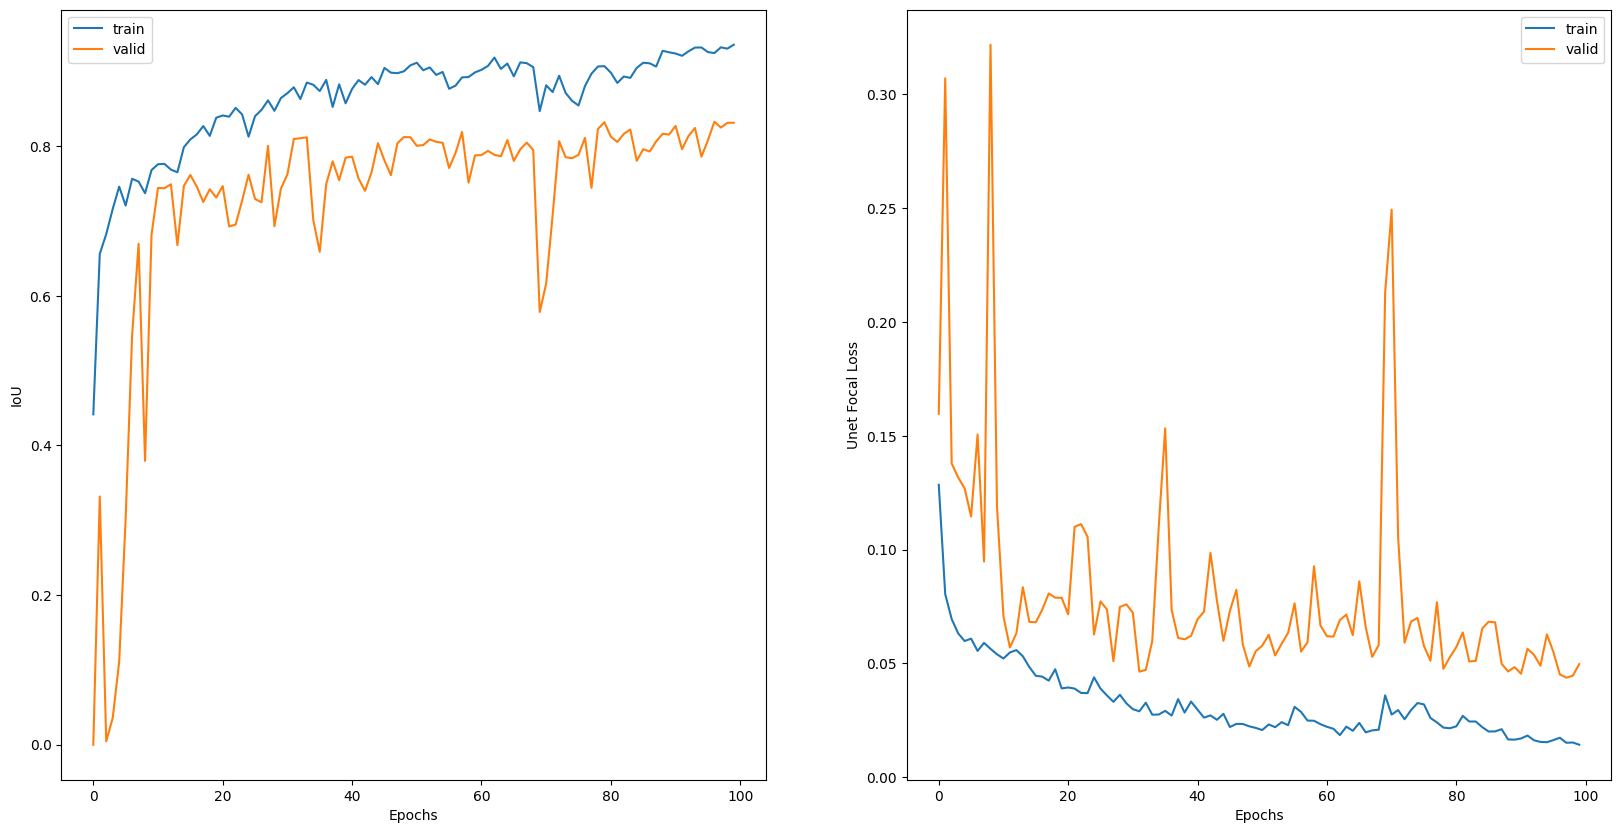

In [ ]:
fig, axs = plt.subplots(1,2, figsize=[20,10])
axs[0].plot(history['train']['iou'], label="train")
axs[0].plot(history['val']['iou'], label="valid")
axs[0].legend(loc='best')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("IoU")

axs[1].plot(history['train']['loss'], label="train")
axs[1].plot(history['val']['loss'], label="valid")
axs[1].legend(loc='best')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Unet Focal Loss")

plt.show()

In [ ]:
best_epoch

97

In [ ]:
iou_test = test(unet_model_focal, test_dataloader, device, best_epoch, 'unet_focal')
print(iou_test.item())

0.8150941133499146


# Вывод

* Лучшее значение по метрике IoU у модели Unet на DiceLoss (0.849).
* Лучшее значение по loss у модели SegNet на FocalLoss (0,036).
* SegNet обучается быстрее .

In [ ]:
segnet = SegNet()
segnet.load_state_dict(torch.load(f'dice/95.pth', weights_only=False))
segnet.eval()
segnet.to(device)

SegNet(
  (enc0): EncoderBlock(
    (layers): ModuleList(
      (0): ConvReLU(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvReLU(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc1): EncoderBlock(
    (layers): ModuleList(
      (0): ConvReLU(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvReLU(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), 

In [ ]:
unet = UNet()
unet.load_state_dict(torch.load(f'unet_dice/93.pth', weights_only=False))
unet.eval()
unet.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

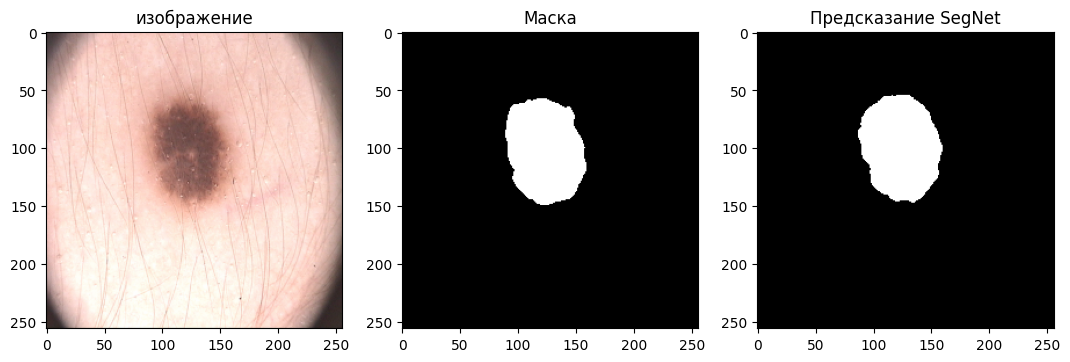

In [ ]:
tensor = torch.Tensor(X[ts][8]).permute(2,0,1).unsqueeze(0)
segnet_mask = segnet(tensor.to(device))
segnet_mask = torch.sigmoid(segnet_mask)
segnet_mask = torch.where(segnet_mask > 0.5, 1, 0)
segnet_mask = segnet_mask.cpu().squeeze(0,1).detach().numpy()

fig, axs = plt.subplots(1,3, figsize=[13,15])
axs[0].imshow(X[ts][8])
axs[0].set_title('изображение')
axs[0].grid(False)

axs[1].imshow(Y[ts][8], cmap='gray')
axs[1].set_title('Маска')
axs[1].grid(False)

axs[2].imshow(segnet_mask, cmap='gray')
axs[2].set_title('Предсказание SegNet')
axs[2].grid(False)

plt.show()

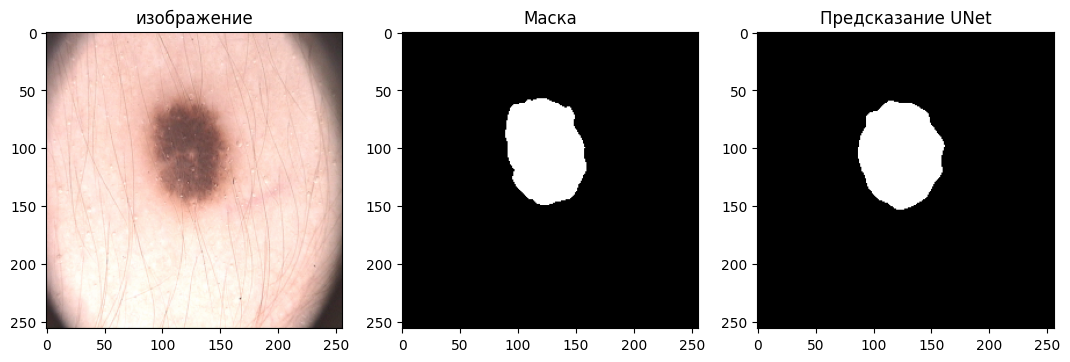

In [ ]:
tensor = torch.Tensor(X[ts][8]).permute(2,0,1).unsqueeze(0)
unet_mask = unet(tensor.to(device))
unet_mask = torch.sigmoid(unet_mask)
unet_mask = torch.where(unet_mask > 0.5, 1, 0)
unet_mask = unet_mask.cpu().squeeze(0,1).detach().numpy()

fig, axs = plt.subplots(1,3, figsize=[13,15])
axs[0].imshow(X[ts][8])
axs[0].set_title('изображение')
axs[0].grid(False)

axs[1].imshow(Y[ts][8], cmap='gray')
axs[1].set_title('Маска')
axs[1].grid(False)

axs[2].imshow(unet_mask, cmap='gray')
axs[2].set_title('Предсказание UNet')
axs[2].grid(False)

plt.show()